In [2]:
# Імпорт необхідних бібліотек для проекту
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from termcolor import colored as cl # Для налаштування тексту
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics, model_selection
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    f1_score,
)

ATTRS = ["bold"]
COLOR = "blue"

In [3]:

df = pd.read_csv("creditcard.csv")

print(cl("Розмір бази {}".format(df.shape), attrs=ATTRS, color=COLOR))
print(
    cl("Дубльовані занчення {}".format(df.duplicated().sum()), attrs=ATTRS, color=COLOR)
)
print(cl("Нульові значення {}".format(df.isnull().sum().sum()), attrs=ATTRS, color=COLOR))


df.drop_duplicates(inplace=True)

Розмір бази (284807, 31)
Дубльовані занчення 1081
Нульові значення 0


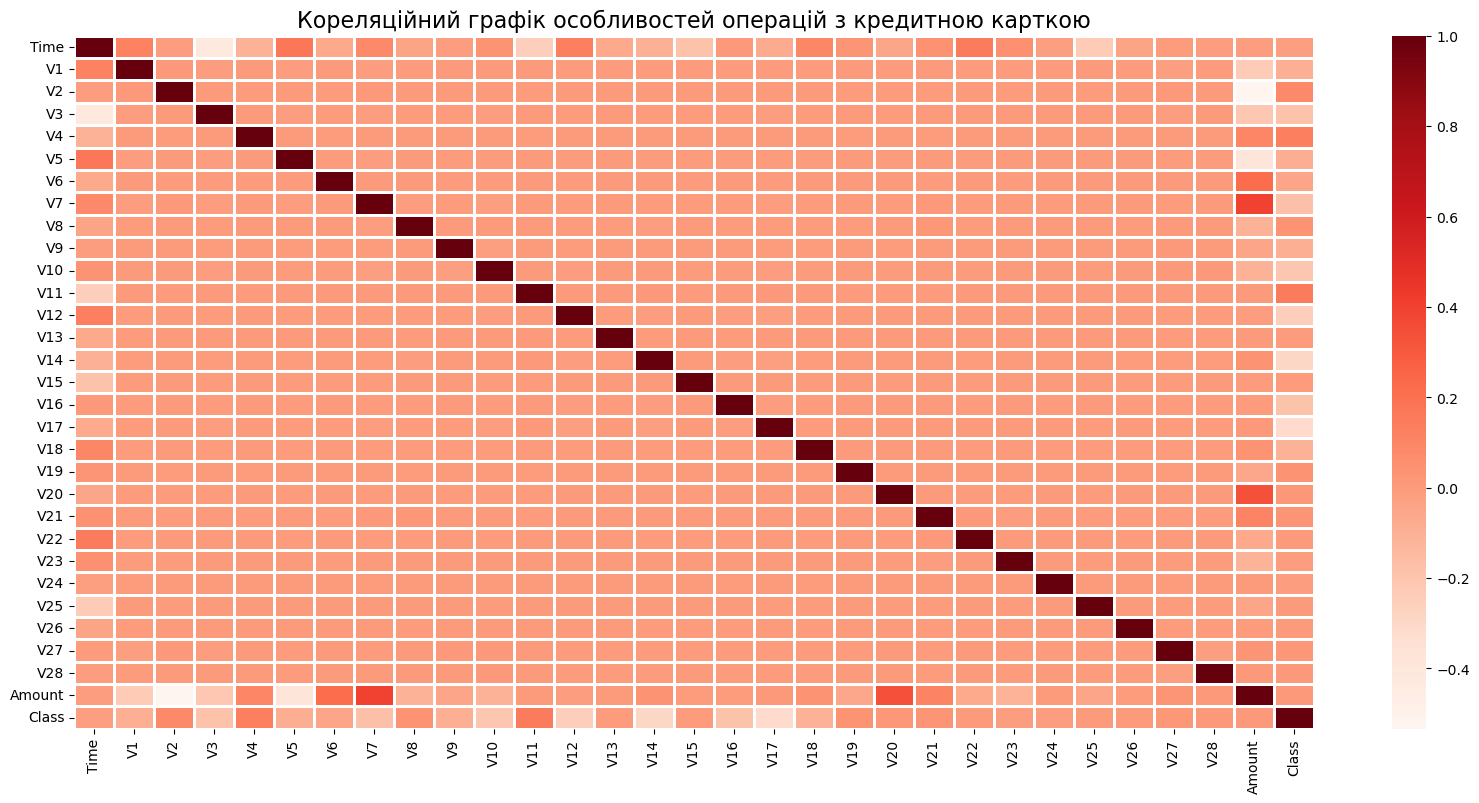

In [6]:

correlation = df.corr()
correlation["Class"].sort_values(ascending=False)
plt.figure(figsize=(20, 9))
plt.title("Кореляційний графік особливостей операцій з кредитною карткою", fontsize=16)
sns.heatmap(
    correlation,
    xticklabels=correlation.columns,
    yticklabels=correlation.columns,
    linewidth=2,
    cmap="Reds",
    cbar=True,
)
plt.show()

In [7]:
print(
    cl(
        "Розмір набору даних до зменшення розмірності: {}".format(
            df.shape
        ),
        attrs=ATTRS,
        color=COLOR,
    )
)
columns = list(df.columns)
for column in columns:
    if column == "Class":
        continue

    filtered_columns = [column]
    for col in df.columns:
        if (column == col) | (column == "Class"):
            continue
        cor_val = df[column].corr(df[col])
        if cor_val > 0.7:
            columns.remove(col)
            continue
        else:
            filtered_columns.append(col)
    df = df[filtered_columns]

features = df.drop(["Class"], axis=1)

scaler = MinMaxScaler((0, 1))
X = scaler.fit_transform(features)
selector = SelectKBest(chi2, k=21)
selector.fit(X, df["Class"])
filtered_columns = selector.get_support()

filtered_data = features.loc[:, filtered_columns]
df = filtered_data.join(df["Class"])

print(
    cl(
        "Розмір набору даних зараз становить: {}".format(df.shape),
        attrs=ATTRS,
        color=COLOR,
    )
)

Розмір набору даних до зменшення розмірності: (283726, 31)
Розмір набору даних зараз становить: (283726, 22)


ІНФОРМАЦІЯ ПРО ТРАНЗАКЦІЇ В БАЗІ ДАНИХ
--------------------------------------------------
Загальна кількість транзакцій становить283726
Кількість справжніх транзакцій становить 283253
Кількість шахрайських транзакцій 473
Відсоток шахрайських транзакцій становить 0.1667%
--------------------------------------------------


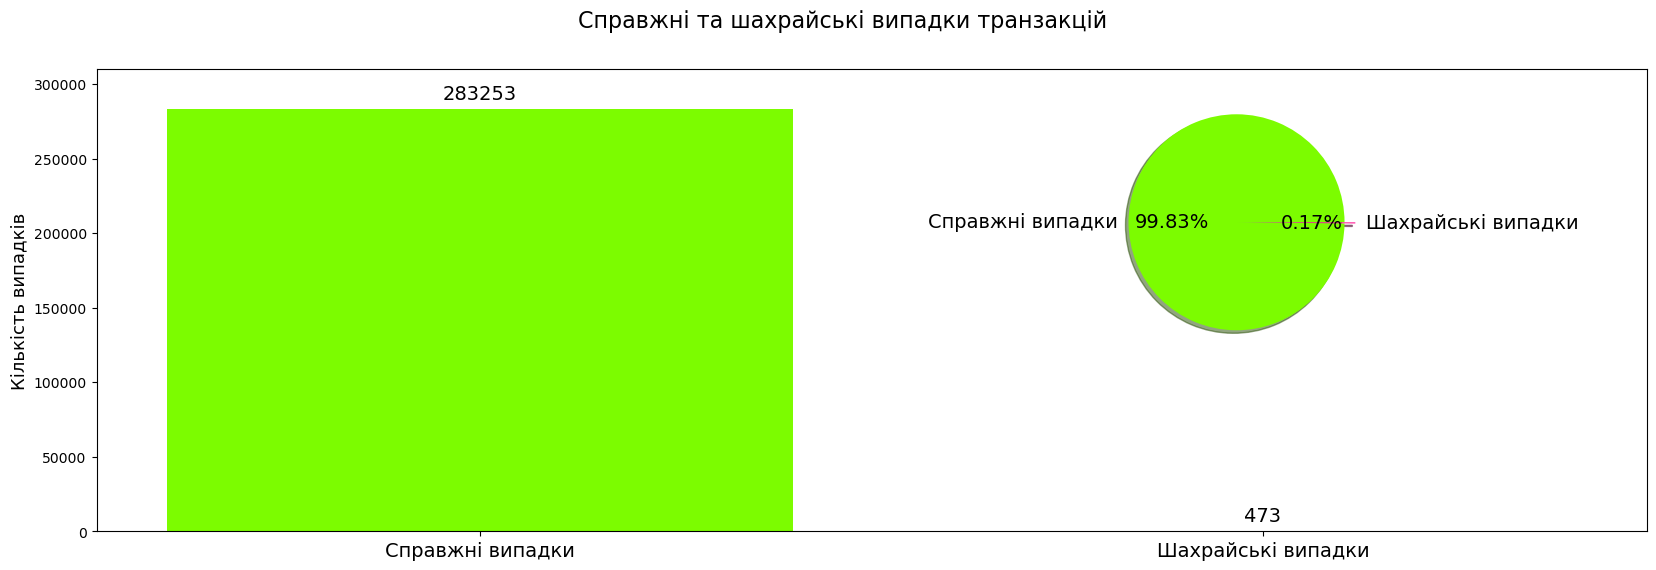

In [10]:
fraudulent_transactions = df.query("Class==1")
genuine_transactions = df.query("Class==0")
total_cases = len(df)
fraudulent_count = len(fraudulent_transactions)
genuine_count = len(genuine_transactions)
fraudulent_percent = round(fraudulent_count / total_cases * 100, 4)

print(cl("ІНФОРМАЦІЯ ПРО ТРАНЗАКЦІЇ В БАЗІ ДАНИХ", attrs=["bold"], color="green"))
print(
    cl(
        "--------------------------------------------------",
        attrs=["bold"],
        color="green",
    )
)
print(
    cl(
        "Загальна кількість транзакцій становить{}".format(total_cases),
        attrs=["bold"],
        color="green",
    )
)
print(
    cl(
        "Кількість справжніх транзакцій становить {}".format(genuine_count),
        attrs=["bold"],
        color="green",
    )
)
print(
    cl(
        "Кількість шахрайських транзакцій {}".format(fraudulent_count),
        attrs=["bold"],
        color="green",
    )
)
print(
    cl(
        "Відсоток шахрайських транзакцій становить {}%".format(fraudulent_percent),
        attrs=["bold"],
        color="green",
    )
)
print(
    cl(
        "--------------------------------------------------",
        attrs=["bold"],
        color="green",
    )
)

cases = ["Справжні випадки", "Шахрайські випадки"]
colors = ["lawngreen", "deeppink"]

data = [genuine_count, fraudulent_count]
explode = (0, 0.1)
LEFT = 0.47
BOTTOM = 0.4
WIDTH = 0.45
HEIGHT = 0.45


fig, axes = plt.subplots(figsize=(20, 6))
ax = fig.add_axes([LEFT, BOTTOM, WIDTH, HEIGHT])

axes.bar(
    cases,
    data,
    color=colors,
)
axes.set_ylabel("Кількість випадків", fontsize=13)
axes.set_ylim(0, 310000)
axes.tick_params(axis="x", labelsize=14)
axes.bar_label(axes.containers[0], padding=4, fontsize=14)
ax.pie(
    data,
    labels=cases,
    explode=explode,
    shadow=True,
    colors=colors,
    autopct="%.2f%%",
    textprops={"fontsize": 14},
)
fig.suptitle(
    "Справжні та шахрайські випадки транзакцій ", fontsize=16
)
plt.show()

In [14]:
print(cl("Деталі кількості шахрайських операцій:", attrs=ATTRS, color=COLOR))
print(cl(fraudulent_transactions.Amount.describe(), attrs=ATTRS, color=COLOR))
print(
    cl("----------------------------------------------------", attrs=ATTRS, color=COLOR)
)
print(
    cl("----------------------------------------------------", attrs=ATTRS, color=COLOR)
)
print(cl("Деталі кількості справжніх транзакцій::", attrs=ATTRS, color=COLOR))
print(cl(genuine_transactions.Amount.describe(), attrs=ATTRS, color=COLOR))

print(
    cl("----------------------------------------------------", attrs=ATTRS, color=COLOR)
)

Деталі кількості шахрайських операцій:
count     473.000000
mean      123.871860
std       260.211041
min         0.000000
25%         1.000000
50%         9.820000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64
----------------------------------------------------
----------------------------------------------------
Деталі кількості справжніх транзакцій::
count    283253.000000
mean         88.413575
std         250.379023
min           0.000000
25%           5.670000
50%          22.000000
75%          77.460000
max       25691.160000
Name: Amount, dtype: float64
----------------------------------------------------


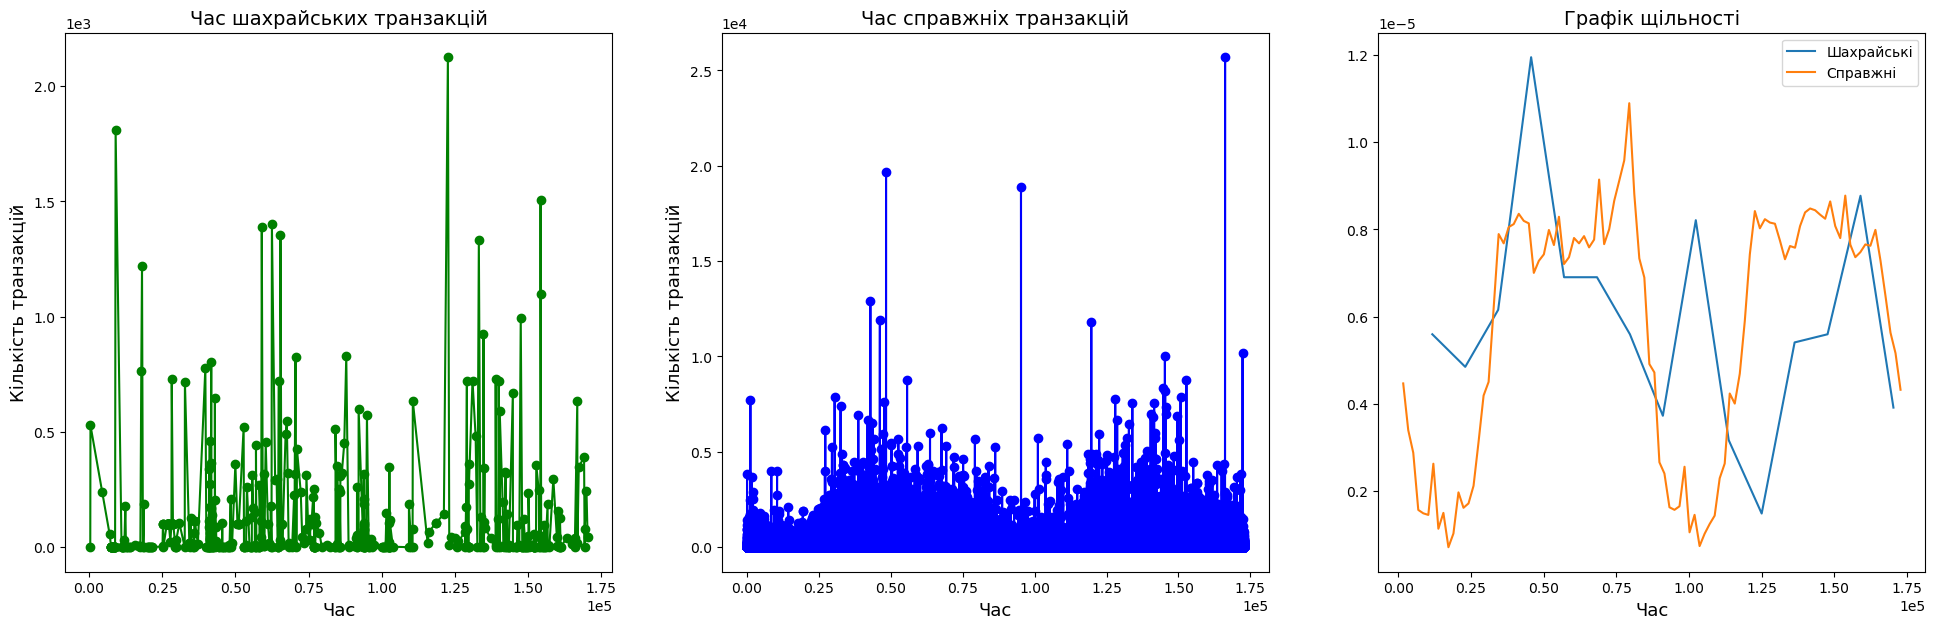

In [19]:
def plot_line(x, y, title="", xlabel="", ylabel="", color=""):
    plt.plot(x, y, color)
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))


a = plt.hist(fraudulent_transactions["Time"], 15, density=True)
b = plt.hist(genuine_transactions["Time"], 100, density=True)
plt.close()

plt.figure(figsize=(24, 7))
plt.subplot(1, 3, 1)
plot_line(
    x=fraudulent_transactions["Time"],
    y=fraudulent_transactions["Amount"],
    title="Час шахрайських транзакцій",
    xlabel="Час",
    ylabel="Кількість транзакцій",
    color="g-o",
)
plt.subplot(1, 3, 2)
plot_line(
    x=genuine_transactions["Time"],
    y=genuine_transactions["Amount"],
    title="Час справжніх транзакцій",
    xlabel="Час",
    ylabel="Кількість транзакцій",
    color="b-o",
)
plt.subplot(1, 3, 3)

plt.plot(a[1][1:], a[0], label="Шахрайські")
plt.plot(b[1][1:], b[0], label="Справжні")
plt.xlabel("Час", fontsize=13)
plt.title("Графік щільності", fontsize=14)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.legend()

Діапазон суми в даних становить 102.60089068346085. Ось чому нам потрібно масштабувати цільову змінну, оскільки функції є трансформованою версією PCA.
Оцінки перехресної перевірки різних алгоритмів
----------------------------------------------------------
ЗАГАЛЬНИЙ ЧАС НА ВИКОНАННЯ RFC це 0.21392416954040527
ROCAUC оцінка RFC це 0.9476389602450461
Оцінка точності RFC це 0.9793818066471646
F1 оцінка RFC це 0.12946428571428573
----------------------------------------------------------
ЗАГАЛЬНИЙ ЧАС НА ВИКОНАННЯ XGB це 0.11967945098876953
ROCAUC оцінка XGB це 0.9281746315622245
Оцінка точності XGB це 0.9195361787614986
F1 оцінка XGB це 0.03752107925801011
----------------------------------------------------------
ЗАГАЛЬНИЙ ЧАС НА ВИКОНАННЯ SMV це 0.2802886962890625
ROCAUC оцінка SMV це 0.5644174070416372
Оцінка точності SMV це 0.5604271666725408
F1 оцінка SMV це 0.004311033051253394
----------------------------------------------------------
-----------------------------------------------

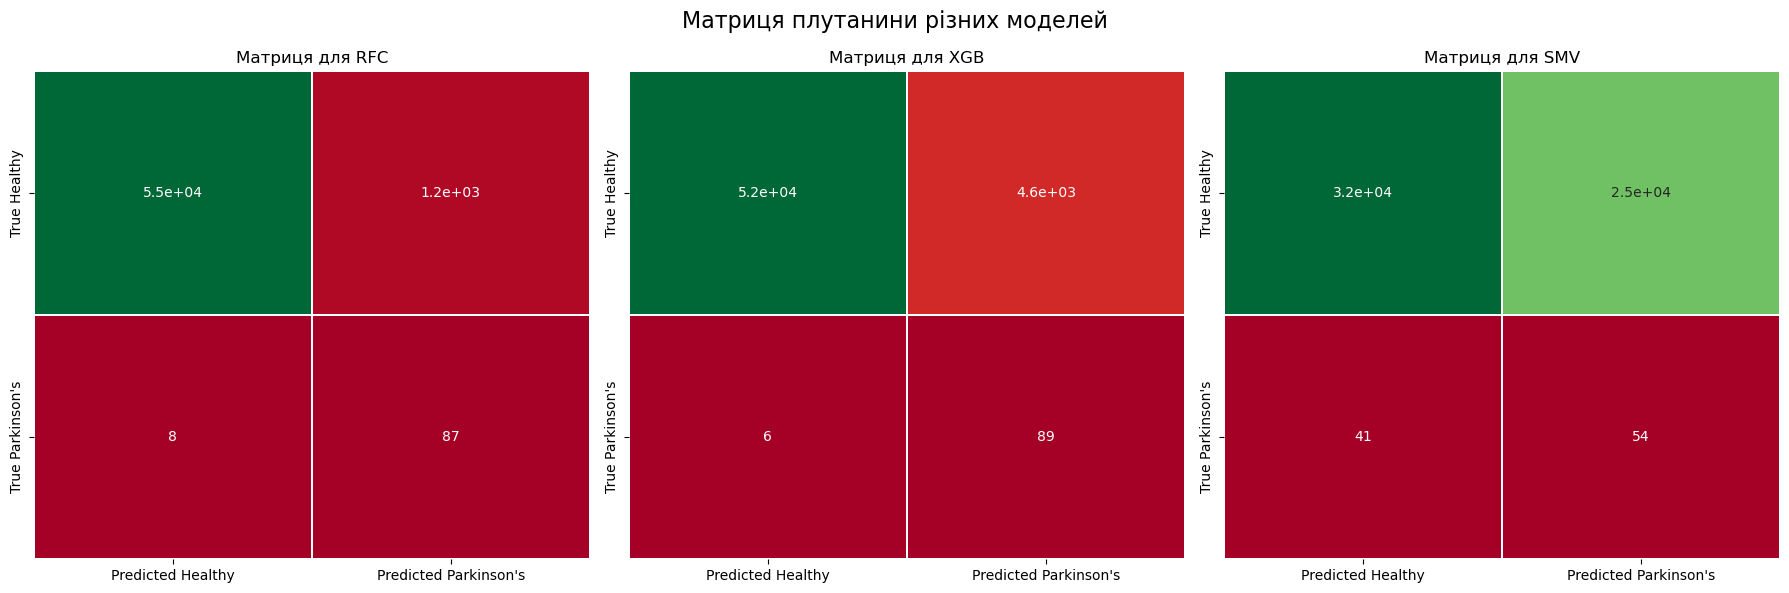

In [23]:


amount_range = max(df["Amount"]) - min(df["Amount"])
print(
    cl(
        "Діапазон суми в даних становить {}. Ось чому нам потрібно масштабувати цільову змінну, оскільки функції є трансформованою версією PCA.".format(
            amount_range
        ),
        attrs=ATTRS,
        color=COLOR,
    )
)

scaler = StandardScaler()
amount = df["Amount"].values
df["Amount"] = scaler.fit_transform(amount.reshape(-1, 1))

y = df["Class"]
X = df.drop("Class", axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=51, shuffle = True, stratify = y
)
ros = RandomOverSampler(sampling_strategy="minority", random_state=1)
rus = RandomUnderSampler(random_state=1)
X_train, y_train = rus.fit_resample(X_train, y_train)

n_estimators = 10

models = []

models.append(("RFC", RandomForestClassifier(class_weight="balanced", n_jobs=40)))
models.append(("XGB", XGBClassifier(scale_pos_weight=99)))
models.append(("SMV", SVC(class_weight="balanced", probability=True)))
scoring11 = ["accuracy", "precision", "recall", "f1", "roc_auc"]
scoring = "accuracy"
cross_val_results = {}
cm_results = {}
print(cl("Оцінки перехресної перевірки різних алгоритмів", attrs=ATTRS, color=COLOR))
print(
    cl(
        "----------------------------------------------------------",
        attrs=ATTRS,
        color=COLOR,
    )
)
for name, model in models:
    start = time.time()
    
    md = model.fit(X_train, y_train)
    end = time.time()
    y_pred = md.predict(X_test)
    cm = pd.DataFrame(
        confusion_matrix(y_test, y_pred),
        columns=["Predicted Healthy", "Predicted Parkinson's"],
        index=["True Healthy", "True Parkinson's"],
    )
    cm_results[name] = cm
   
    print(
        cl(
            "ЗАГАЛЬНИЙ ЧАС НА ВИКОНАННЯ {} це {}".format(name, end - start),
            attrs=ATTRS,
            color=COLOR,
        )
    )
    print(
        cl(
            "ROCAUC оцінка {} це {}".format(name, roc_auc_score(y_test, y_pred)),
            attrs=ATTRS,
            color=COLOR,
        )
    )
    print(
        cl(
            "Оцінка точності {} це {}".format(name, accuracy_score(y_test, y_pred)),
            attrs=ATTRS,
            color=COLOR,
        )
    )
    print(
        cl(
            "F1 оцінка {} це {}".format(name, f1_score(y_test, y_pred)),
            attrs=ATTRS,
            color=COLOR,
        )
    )
    print(
        cl(
            "----------------------------------------------------------",
            attrs=ATTRS,
            color=COLOR,
        )
    )
print(
    cl(
        "----------------------------------------------------------",
        attrs=ATTRS,
        color=COLOR,
    )
)

c = 1
plt.figure(figsize=(18, 6))
for i in cm_results:
    plt.subplot(1, 3, c)
    plt.suptitle("Матриця плутанини різних моделей", fontsize=16)
    sns.heatmap(
        cm_results[i],
        cmap="RdYlGn",
        linewidth=0.2,
        annot=True,
        cbar=False,
    )
    plt.title("Матриця для {}".format(i))
    c = c + 1
plt.tight_layout()
plt.show()

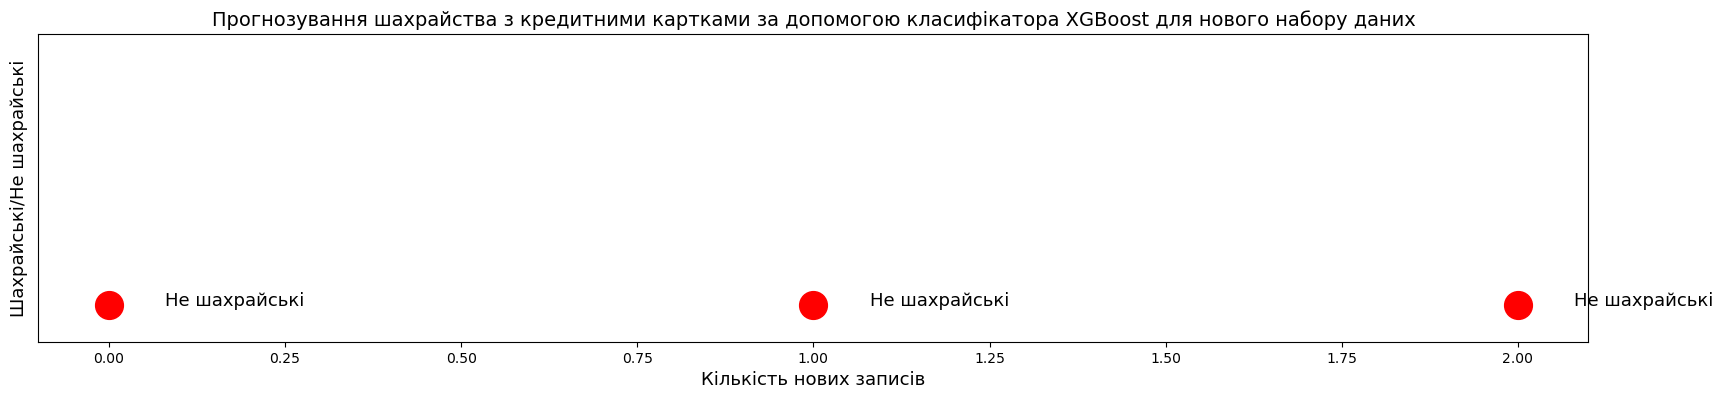

In [24]:
col = [
    "Amount",
    "V26",
    "V24",
    "V19",
    "V18",
    "V17",
    "V16",
    "V14",
    "V12",
    "V11",
    "V10",
    "V9",
    "V8",
    "V7",
    "V6",
    "V5",
    "V4",
    "V3",
    "V2",
    "V1",
    "Time",
]
val = [
    [
        349.62,
        -0.129115,
        0.045928,
        0.803443,
        0.045791,
        0.327894,
        -0.320401,
        -0.311169,
        -0.4875,
        -4.36123,
        -2.34223,
        0.12345,
        0.348756,
        0.462388,
        -0.231234,
        2.3456,
        3.45223,
        2.3221,
        -0.072781,
        -2.34567,
        0,
    ],
    [
        549.62,
        -0.429135,
        0.0239258,
        0.40343,
        0.025791,
        0.627894,
        -0.120401,
        -0.467169,
        -0.9874,
        -2.36143,
        -1.31253,
        0.22444,
        0.146776,
        0.241288,
        -0.13224,
        1.345622,
        1.45223,
        4.23122,
        -0.073112,
        -4.34569,
        1,
    ],
    [
        49.62,
        -0.729135,
        0.0539258,
        0.70343,
        0.085791,
        0.227894,
        -0.420401,
        -0.767169,
        -0.2874,
        -4.36143,
        -4.31253,
        0.82444,
        0.246776,
        0.541288,
        -0.53224,
        4.345622,
        3.45223,
        5.23122,
        -0.093112,
        -2.34569,
        2,
    ],
]

df_new = pd.DataFrame(data=val, columns=col)
amount = df_new["Amount"].values
df_new["Amount"] = scaler.fit_transform(amount.reshape(-1, 1))

rfc = RandomForestClassifier(class_weight="balanced", n_jobs=40).fit(X_test, y_test)
y_pred = rfc.predict(df_new)

lbl = []
for i in y_pred:
    if i == 1:
        lbl.append("Шахрайські")
    else:
        lbl.append("Не шахрайські")
plt.figure(figsize=(20, 4))
my_x = [i for i in range(len(y_pred))]
plt.scatter(my_x, y_pred, c="red", s=400)
for i, txt in enumerate(lbl):
    plt.annotate(txt, (my_x[i] + 0.08, y_pred[i]), fontsize=13)
plt.title(
    "Прогнозування шахрайства з кредитними картками за допомогою класифікатора XGBoost для нового набору даних",
    fontsize=14,
)
plt.xlabel("Кількість нових записів", fontsize=13)
plt.ylabel("Шахрайські/Не шахрайські", fontsize=13)
plt.yticks(ticks=())
plt.ylim(-0.2, 1.5)
plt.show()